In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
df = gpd.read_file("data/semiology_of_graphics.geojson").set_index("code")

In [2]:
# generate a grid

grain = 30
x1, y1, x0, y0 = df.total_bounds
xv, yv = np.meshgrid(
    np.linspace(x0, x1, grain), 
    np.linspace(y0, y1, grain)
)

In [3]:
# uncomment to get a hexagonal grid

# delta = (yv[0,0] - yv[1,0])/4
# a = np.empty((grain,))
# a[::2] = delta
# a[1::2] = -delta
# yv += a

In [4]:
# create a new data frame of points and figure out which department each points is in

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xv.flatten(), yv.flatten())).set_crs(df.crs)

codes = []

for point in gdf.geometry:
    code = None
    for index, row in df.iterrows():
        if point.within(row.geometry):
            code = index
            continue
    codes.append(code)
    
# force a couple of points in the top right to be Paris and Seine
codes[3] = "P"
codes[5] = "75"

gdf["code"] = codes

# drop any points that didn't fall into a department
gdf = gdf.dropna()

In [5]:
# figure out how many points fell within each department

gdf = gdf.merge(
    pd.DataFrame((1/gdf.code.value_counts().rename("department_fraction")).reset_index()), 
    left_on="code", right_on="index"
).drop("index", axis=1)

In [6]:
# merge the department data and allocate it among the points in each department

gdf = gdf.merge(df[['agriculture', 'industry', 'services', 'department', 'total']].reset_index())
gdf.total = (gdf.total * gdf.department_fraction).astype(int)
gdf.agriculture = (gdf.agriculture * gdf.department_fraction).astype(int)
gdf.industry = (gdf.industry * gdf.department_fraction).astype(int)
gdf.services = (gdf.services * gdf.department_fraction).astype(int)

In [8]:
# uncomment to save the file

# gdf.to_file("data/semiology_of_graphics_points.geojson", driver="GeoJSON")

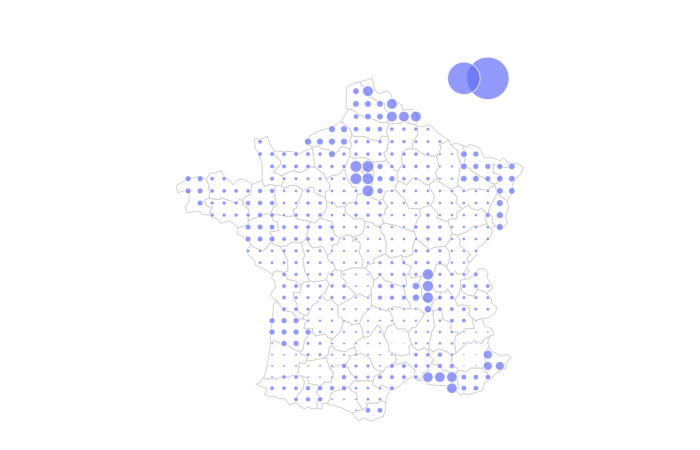

In [9]:
# plot the resulting `services` data

import plotly.express as px

fig = px.scatter_geo(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, 
                     size="services", size_max=30, fitbounds="geojson", 
                     projection="mercator", basemap_visible=False)
basepolygons = (
    px.choropleth(df, geojson=df.geometry, locations=df.index, color_discrete_sequence=["white"])
    .update_traces(marker_line_color="lightgrey", showlegend=False)
    .data[0]
)

fig.update_layout(showlegend=False, height=400, margin=dict(t=40, b=0, r=0, l=0))
fig.add_trace(basepolygons)
fig.show("svg")